In [1]:
import torch
import pickle

import matplotlib.pyplot as plt

from dataclasses import dataclass
from torch.utils.data import Dataset

In [2]:
# with open(f'./data/hawkes_train_mark_1_1024.pickle', 'rb') as f:
with open(f'./data/hawkes_train_mark_1.pickle', 'rb') as f:
    train_data = pickle.load(f)

with open(f'./data/hawkes_eval_mark_1.pickle', 'rb') as f:
    eval_data = pickle.load(f)

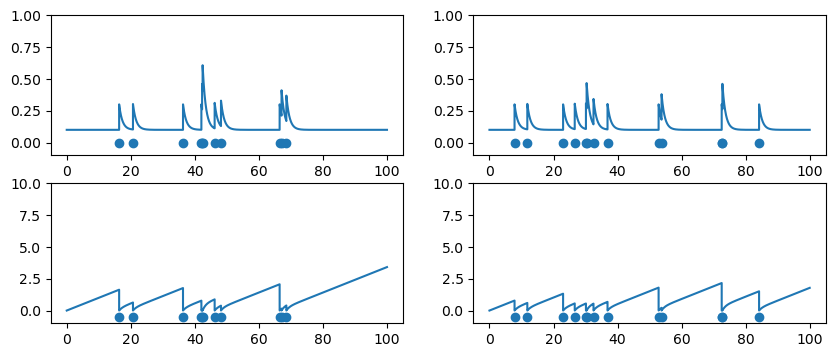

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(10, 4))

ax[0][0].set_ylim(-0.1, 1)
ax[0][1].set_ylim(-0.1, 1)
ax[1][0].set_ylim(-1, 10)
ax[1][1].set_ylim(-1, 10)

ax[0][0].plot(train_data[0]['timestamps'], train_data[0]['intensity'])
ax[0][0].scatter(train_data[0]['times'], torch.zeros_like(train_data[0]['times']))

ax[0][1].plot(eval_data[0]['timestamps'], eval_data[0]['intensity'])
ax[0][1].scatter(eval_data[0]['times'], torch.zeros_like(eval_data[0]['times']))

ax[1][0].plot(train_data[0]['timestamps'], train_data[0]['cumu_intensity'])
ax[1][0].scatter(train_data[0]['times'], torch.zeros_like(train_data[0]['times'])-0.5)

ax[1][1].plot(eval_data[0]['timestamps'], eval_data[0]['cumu_intensity'])
ax[1][1].scatter(eval_data[0]['times'], torch.zeros_like(eval_data[0]['times'])-0.5)

In [4]:
@dataclass
class ModelTrainingConfig:
    output_dir: str

    temporal_embedding_dim = 16
    seq_len = 48
    dt = 0.01
    start_time = 0
    end_time = 100
    self_attn_n_layers = 1
    self_attn_input_dim = 16
    self_attn_n_head = 1
    log_intensity_input_dim = 16 * 2
    log_intensity_hidden_dim = 32 * 2
    log_intensity_output_dim = 1
    monte_carlo_sample_num = 100

    train_batch_size = 64
    num_epochs = 1000
    eval_epochs = 500
    gradient_accumulation_steps = 1
    learning_rate = 2e-3
    lr_warmup_steps = 1000
    save_model_epochs = 5
    mixed_precision = 'no'
    seed = 3407
    push_to_hub = False
    overwrite_output_dir = True

config = ModelTrainingConfig(output_dir='./Hawkes1D')

In [5]:
class HawkesDataset(Dataset):
    def __init__(self, events_data):
        self.prev_times = []
        self.marks = []
        self.delta_times = []
        self.history_masks = []
        
        for event in events_data:
            event_num = event['event_num']
            raw_t = event['times']
            
            with_start = torch.nn.functional.pad(raw_t, pad=[1,0], value=config.start_time)
            with_end = torch.nn.functional.pad(raw_t, pad=[0,1], value=config.end_time)
            intervals = with_end - with_start
            intervals = torch.nn.functional.pad(intervals, pad=[0, config.seq_len - len(intervals)], value=-1)
            
            time_prev = with_start
            mark_prev = torch.ones_like(time_prev, dtype=torch.int64)
            time_prev = torch.nn.functional.pad(time_prev, pad=[0, config.seq_len - len(time_prev)], value=-1)
            mark_prev = torch.nn.functional.pad(mark_prev, pad=[0, config.seq_len - len(mark_prev)], value=0)

            hist_mask = torch.triu(torch.ones(config.seq_len, config.seq_len) * -float('inf'), diagonal=1)

            self.prev_times.append(time_prev)
            self.marks.append(mark_prev)
            self.delta_times.append(intervals)
            self.history_masks.append(hist_mask)
        
        self.length = len(events_data)
    
    def __getitem__(self, index):
        return (
            self.prev_times[index],
            self.marks[index],
            self.delta_times[index],
            self.history_masks[index],
        )
    
    def __len__(self):
        return self.length

In [6]:
train_dataset = HawkesDataset(train_data)

In [7]:
from diffusers import ModelMixin, DiffusionPipeline
from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.utils import BaseOutput

In [8]:
@dataclass
class SelfAttnPipelineOutput(BaseOutput):
    intensity: torch.FloatTensor
    cumu_intensity: torch.FloatTensor
    timestamps: torch.FloatTensor

class SelfAttnPipeline(DiffusionPipeline):
    @register_to_config
    def __init__(
        self,
        mark_encoder: ModelMixin,
        temporal_encoder: ModelMixin,
        self_attention_encoder: ModelMixin,
        log_intensity_decoder: ModelMixin,
    ):
        super().__init__()
        self.register_modules(
            mark_encoder=mark_encoder,
            temporal_encoder=temporal_encoder,
            self_attention_encoder=self_attention_encoder,
            log_intensity_decoder=log_intensity_decoder,
        )

    @torch.no_grad()
    def __call__(
        self,
        raw_times,
        config: ModelTrainingConfig
    ):
        self.mark_encoder.eval()
        self.temporal_encoder.eval()
        self.self_attention_encoder.eval()
        self.log_intensity_decoder.eval()
        device = self.mark_encoder.device
        raw_t = torch.FloatTensor(raw_times).to(device)
        
        with_start = torch.nn.functional.pad(raw_t, pad=[1,0], value=config.start_time)
        with_end = torch.nn.functional.pad(raw_t, pad=[0,1], value=config.end_time)
        intervals = with_end - with_start
        intervals = torch.nn.functional.pad(intervals, pad=[0, config.seq_len - len(intervals)], value=-1)
        
        prev_t = with_start
        prev_marks = torch.ones_like(prev_t, dtype=torch.int64)
        prev_t = torch.nn.functional.pad(prev_t, pad=[0, config.seq_len - len(prev_t)], value=-1)
        prev_marks = torch.nn.functional.pad(prev_marks, pad=[0, config.seq_len - len(prev_marks)], value=0)

        hist_mask = torch.triu(torch.ones(config.seq_len, config.seq_len) * -float('inf'), diagonal=1).to(device)

        times_R = self.temporal_encoder(prev_t.unsqueeze(-1))
        marks_R = self.mark_encoder(prev_marks)
        hist_representation = self.self_attention_encoder(times_R + marks_R, hist_mask)

        sample_t = torch.arange(raw_t[0], config.end_time, config.dt).to(device)
        sample_prev_t_idx = torch.searchsorted(raw_t, sample_t, right=True) - 1
        sample_prev_t_idx = torch.clamp_min(sample_prev_t_idx, 0)
        sample_aligned_hist = hist_representation[sample_prev_t_idx]
        sample_query = sample_t - raw_t[sample_prev_t_idx]
        sample_R = self.temporal_encoder(sample_query.unsqueeze(-1))
        sample_log_lambda = self.log_intensity_decoder(sample_R, sample_aligned_hist).squeeze()
        sample_lambda = torch.exp(sample_log_lambda)

        mask = torch.searchsorted(sample_t, raw_t)
        mask = torch.cat([torch.zeros(1).to(device), mask, torch.ones(1).to(device)*len(sample_t)]).to(torch.int)
        sample_Lambda = torch.zeros_like(sample_lambda)
        for start, end in zip(mask[:-1], mask[1:]):
            sample_Lambda[start: end] = torch.cumsum(sample_lambda[start: end], dim=0)
        sample_Lambda *= config.dt

        return SelfAttnPipelineOutput(
            intensity=sample_lambda,
            cumu_intensity=sample_Lambda,
            timestamps=sample_t
        )

In [9]:
import numpy as np

class MarksEncoder(ModelMixin, ConfigMixin):
    config_name = 'MarksEncoder'
    @register_to_config
    def __init__(self, embedding_dim: int):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.block = torch.nn.Embedding(2, embedding_dim)
        
    def forward(self, x):
        return self.block(x) * (self.embedding_dim**0.5)

class TemporalEncoder(ModelMixin, ConfigMixin):
    config_name = 'TemporalEncoder'
    @register_to_config
    def __init__(self, embedding_dim: int):
        super().__init__()
        self.eps = 1e-30
        self.embedding_dim = embedding_dim

    def forward(self, t):
        num_timescales = self.embedding_dim//2
        log_increment = np.log(1e4) / (num_timescales - 1)
        inv_timescales = (
            torch.exp(torch.arange(num_timescales, dtype=torch.float, device=t.device) * -log_increment)
        )
        scaled_t = t * inv_timescales.unsqueeze(0)
        signal = torch.cat([torch.sin(scaled_t), torch.cos(scaled_t)], dim=-1)
        return signal

class SelfAttentionEncoder(ModelMixin, ConfigMixin):
    config_name = 'SelfAttentionEncoder'
    @register_to_config
    def __init__(self, n_layers: int, input_dim: int, n_head: int):
        super().__init__()
        encoder_layer=torch.nn.TransformerEncoderLayer(input_dim, n_head, batch_first=True)
        self.block = torch.nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_layers,
            norm=torch.nn.LayerNorm(input_dim)
        )

    def forward(self, input, mask):
        return self.block(input, mask)

class LogIntensityDecoder(ModelMixin, ConfigMixin):
    config_name = 'LogIntensityDecoder'
    @register_to_config
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()
        self.eps = 1e-30
        self.block = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )
        self.mu = torch.nn.Parameter(torch.Tensor(1))
        torch.nn.init.uniform_(self.mu)
        
        self.alpha = torch.nn.Parameter(torch.Tensor([1., -2.]))

    def forward(self, query, hid):
        log_intensity = self.block(torch.cat([query, hid], dim=-1))
        log_intensity = log_intensity  + self.mu + self.eps
        return log_intensity 

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=config.train_batch_size,
    shuffle=True,
    num_workers=4
)

In [11]:
marks_encoder = MarksEncoder(config.temporal_embedding_dim)
temporal_encoder = TemporalEncoder(config.temporal_embedding_dim)

self_attn_encoder = SelfAttentionEncoder(
    config.self_attn_n_layers,
    config.self_attn_input_dim,
    config.self_attn_n_head
)

log_intensity_decoder = LogIntensityDecoder(
    config.log_intensity_input_dim,
    config.log_intensity_hidden_dim,
    config.log_intensity_output_dim
)

In [12]:
from diffusers.optimization import get_cosine_schedule_with_warmup, get_constant_schedule

optimizer = torch.optim.Adam(
    params=list(temporal_encoder.parameters()) + list(self_attn_encoder.parameters()) + list(log_intensity_decoder.parameters()),
    lr=config.learning_rate,
)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=config.num_epochs * len(train_dataset),
)

In [13]:
import os
from tqdm.auto import tqdm

def evaluate(config: ModelTrainingConfig, epoch: int, pipeline:SelfAttnPipeline, eval_seq):
    test_dir = './eval'
    os.makedirs(test_dir, exist_ok=True)

    for i, seq in enumerate(eval_seq):
        raw_times = seq['times'].tolist()

        # Evaluate
        output = pipeline(raw_times, config)
        intensity = output.intensity
        cumu_intensity = output.cumu_intensity

        _, axs = plt.subplots(2, 1, figsize=(10, 4))
        axs[0].plot(seq['timestamps'], seq['intensity'])
        axs[0].scatter(seq['times'], torch.zeros_like(seq['times']))
        axs[0].plot(output.timestamps.detach().cpu(), intensity.detach().cpu())

        axs[1].plot(seq['timestamps'], seq['cumu_intensity'])
        axs[1].scatter(seq['times'], torch.zeros_like(seq['times']))
        axs[1].plot(output.timestamps.detach().cpu(), cumu_intensity.detach().cpu())
        
        plt.savefig(test_dir + f'/epoch-{epoch}-eval-{i}.png')

  0%|          | 0/1000 [00:00<?, ?it/s]

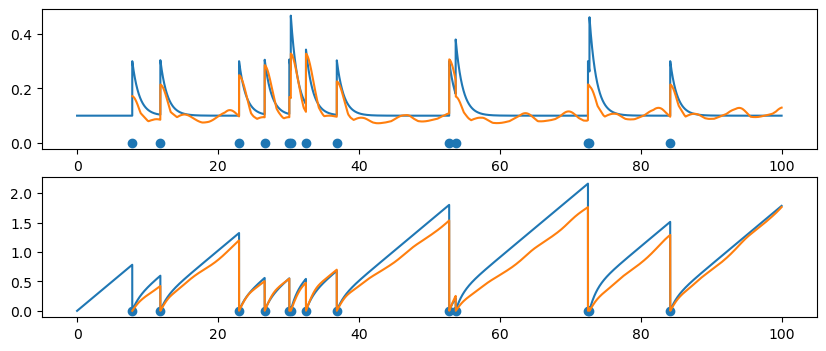

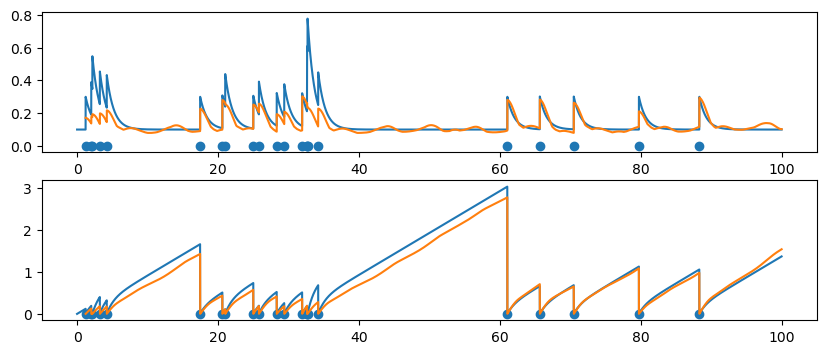

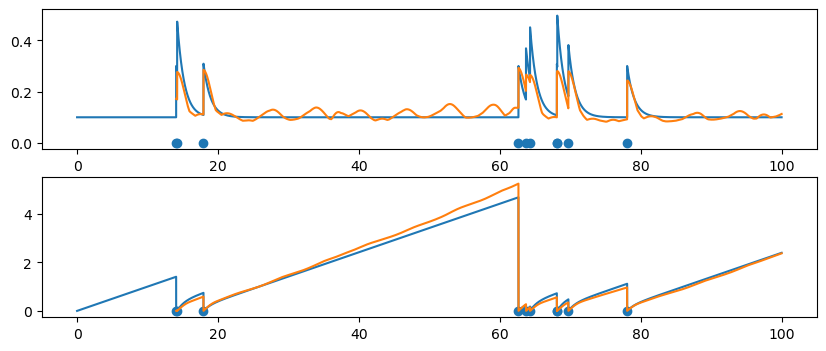

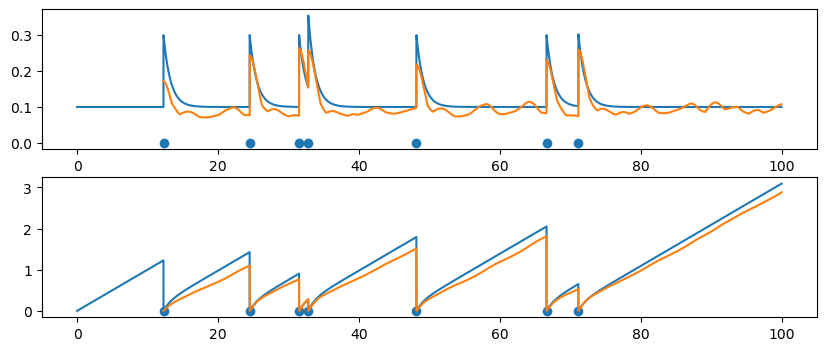

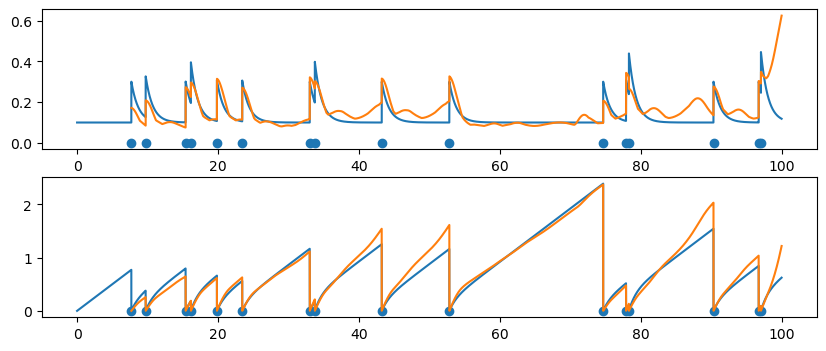

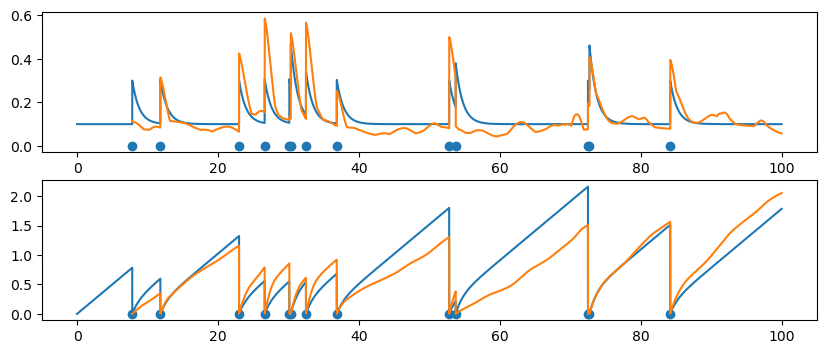

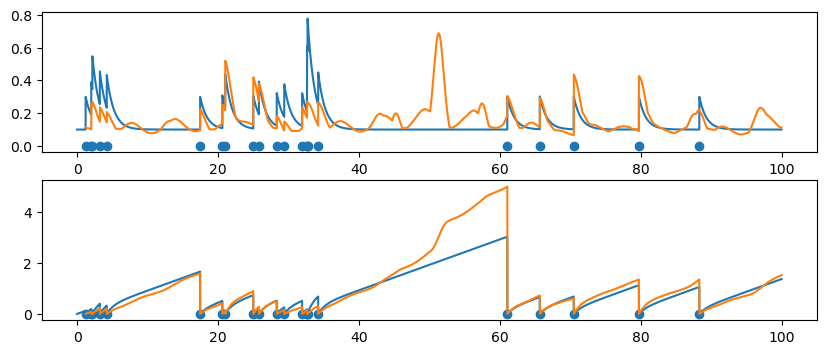

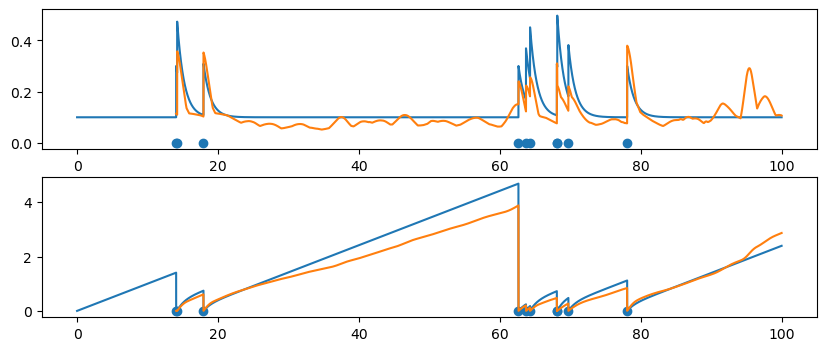

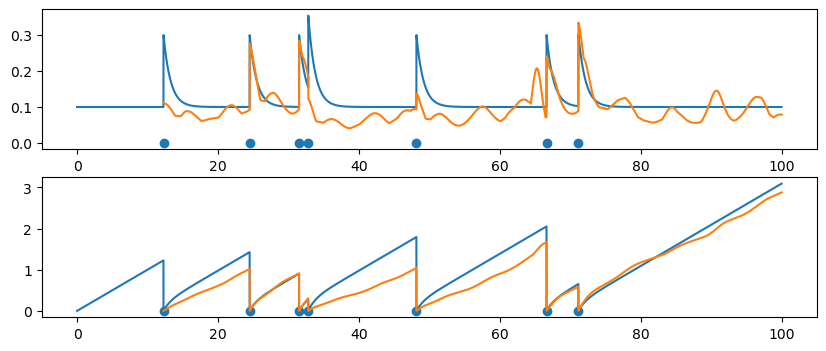

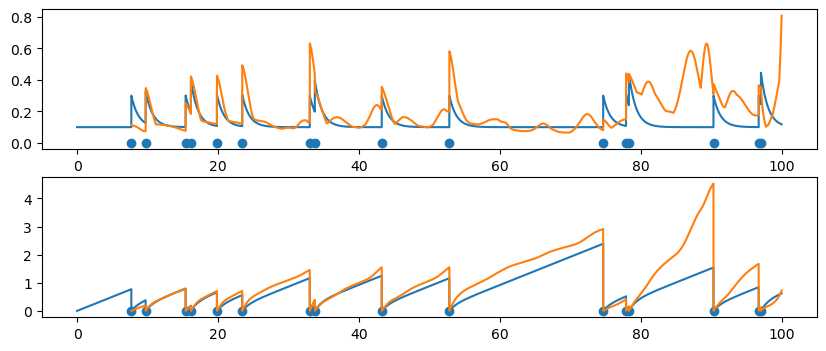

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
progress_bar = tqdm(total=config.num_epochs)
global_steps = 0
for e in range(config.num_epochs):
    marks_encoder.train().to(device)
    temporal_encoder.train().to(device)
    self_attn_encoder.train().to(device)
    log_intensity_decoder.train().to(device)

    progress_bar.set_description(f'Epoch: {e}')
    for prev_t, marks, delta_t, history_masks in train_dataloader:
        prev_t, marks, delta_t, history_masks= (
            prev_t.to(device),
            marks.to(device),
            delta_t.to(device),
            history_masks.to(device),
        )
        history_masks = torch.repeat_interleave(history_masks, config.self_attn_n_head, 0)
        
        times_R = temporal_encoder(prev_t.unsqueeze(-1))
        marks_R = marks_encoder(marks)
        hist_R = self_attn_encoder(times_R + marks_R, history_masks)
        query = delta_t
        query_R = temporal_encoder(query.unsqueeze(-1))
        log_intensity = log_intensity_decoder(query_R, hist_R).squeeze()
        log_intensity = log_intensity * marks
        
        mc_query = torch.rand_like(delta_t) * delta_t
        mc_query_R = temporal_encoder(mc_query.unsqueeze(-1))
        mc_log_intensity = log_intensity_decoder(mc_query_R, hist_R).squeeze()
        mc_intensity = torch.exp(mc_log_intensity)
        mc_integral_intensity = mc_intensity * delta_t * marks
        mc_integral_intensity = torch.sum(mc_integral_intensity, dim=1)
        
        log_sum_intensity = torch.sum(log_intensity, dim=1)
        log_likelihood = log_sum_intensity - mc_integral_intensity
        
        loss = -log_likelihood.mean()
        if loss < 0 or torch.isnan(loss):
            print(log_intensity)
            # print(mc_integral_intensity)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        lr_scheduler.step()
        global_steps += 1

        logs = {
            'loss': loss.detach().item(),
            'lr': lr_scheduler.get_last_lr()[0],
            'global_steps': global_steps
        }
        progress_bar.set_postfix(**logs)

    progress_bar.update()


    if (e + 1) % config.eval_epochs == 0 or e == config.num_epochs - 1:
        pipeline = SelfAttnPipeline(
            marks_encoder,
            temporal_encoder,
            self_attn_encoder,
            log_intensity_decoder
        )
        evaluate(config, e, pipeline, eval_data[:5])

    if (e + 1) % config.save_model_epochs == 0 or e == config.num_epochs - 1:
        pipeline = SelfAttnPipeline(
            marks_encoder,
            temporal_encoder,
            self_attn_encoder,
            log_intensity_decoder
        )
        pipeline.save_pretrained(config.output_dir)